# 실시간 정맥 인증 시스템

In [ ]:
from tkinter import *
from PIL import ImageTk, Image # Pillow
import cv2
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras

####### Tensorflow #######

classes = ["na____left", "na___right", "shin__left", "shin_right"]

num_right_train = 10
num_left_train = 10
num_right1_train = 5
num_left1_train = 5

pic = np.array(Image.open("train\\shin_right" + str(0) + ".jpg"))
train_images = np.array([pic])
train_labels = np.array([3]*num_right_train + [2]*num_left_train + [1]*num_right1_train + [0]*num_left1_train)

for i in range(1, num_right_train):
    pic = np.array(Image.open("train\\shin_right" + str(i) + ".jpg"))
    train_images = np.vstack((train_images, np.array([pic])))

for i in range(num_left_train):
    pic = np.array(Image.open("train\\shin_left" + str(i) + ".jpg"))
    train_images = np.vstack((train_images, np.array([pic])))
    
for i in range(num_right1_train):
    pic = np.array(Image.open("train\\na_right" + str(i) + ".jpg"))
    train_images = np.vstack((train_images, np.array([pic])))
    
for i in range(num_left1_train):
    pic = np.array(Image.open("train\\na_left" + str(i) + ".jpg"))
    train_images = np.vstack((train_images, np.array([pic])))

train_images = train_images / 255.0

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(240, 285)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

####### Tensorflow #######

# GUI 설계
win = Tk() # 인스턴스 생성

win.title("손 정맥 스캐너") # 제목 표시줄 추가
win.option_add("*Font", "맑은고딕 25") # 전체 폰트

#win.resizable(False, False) # x축, y축 크기 조정 비활성화

# 라벨 추가
lbl = Label(win, text="손 정맥 스캐너")
lbl.grid(row=0, column=0, columnspan = 2) # 라벨 행, 열 배치

# 프레임 추가
frm = Frame(win, bg="white", width=720, height=480) # 프레임 너비, 높이 설정
frm.grid(row=1, column=0, columnspan = 2) # 격자 행, 열 배치

# 프레임 추가
frm1 = Frame(win, width=700, height=75) # 프레임 너비, 높이 설정
frm1.grid(row=3, column=0, columnspan = 2) # 격자 행, 열 배치

# 라벨 추가
lbl1 = Label(frm)
lbl1.grid()

cap = cv2.VideoCapture(1) # VideoCapture 객체 정의

def video_play():
   ret, frame = cap.read()
   frame = cv2.flip(frame, 1) # 상하반전
   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

   img = Image.fromarray(frame)
   imgtk = ImageTk.PhotoImage(image=img)

   lbl1.imgtk = imgtk
   lbl1.configure(image=imgtk)
   lbl1.after(10, video_play)

video_play()

# 버튼 추가
btn = Button(win, text = "촬영") # 버튼 생성
btn.grid(row=2, column=0) # 라벨 행, 열 배치
btn.config(width = 5, height = 1) # 버튼 크기

# 버튼 추가
btn1 = Button(win, text = "검증")
btn1.grid(row=2, column=1) # 라벨 행, 열 배치
btn1.config(width = 5, height = 1) # 버튼 크기

def deep():

   ret, frame = cap.read()
   frame = cv2.flip(frame, 1) # Flip camera vertically
    
   cv2.imwrite("live_test\\deep_learning.jpg", frame)
   img = cv2.imread("live_test\\deep_learning.jpg")
    
   img = img[110:350, 165:450].copy()
    
   ####### 이미지 처리 #######
   # noise
   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   noise = cv2.fastNlMeansDenoising(gray)
   noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

   # equalist hist
   kernel = np.ones((7,7),np.uint8)
   img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
   img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
   img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
   img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

   # invert
   inv = cv2.bitwise_not(img_output)

   # erode
   gray = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
   erosion = cv2.erode(gray,kernel,iterations = 1)
    
   # skel
   img = gray.copy()
   skel = img.copy()
   skel[:,:] = 0
   kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
   iterations = 0

   while True:
       eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
       temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
       temp  = cv2.subtract(img, temp)
       skel = cv2.bitwise_or(skel, temp)
       img[:,:] = eroded[:,:]
       if cv2.countNonZero(img) == 0:
           break

   ret, thr = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY);

   cv2.imwrite("live_test\\deep_learning_result.jpg", thr) # 이미지 처리 된 이미지 저장

   ####### 이미지 처리 #######
    
   pic = np.array(Image.open("live_test\\deep_learning_result.jpg"))
   test_images = np.array([pic])
   predictions = model.predict(test_images)
    
   lbl2 = Label(win, text = classes[np.argmax(predictions[0])])
   lbl2.grid(row=3, column=0, columnspan = 2)

def alert():

   ret, frame = cap.read()
   frame = cv2.flip(frame, 1) # Flip camera vertically
   
   # 컬러 이미지 저장
   vein_img = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_ORGINAL") + '.jpg'
   cv2.imwrite(vein_img, frame)
   
   # 컬러 이미지 불러오기 및 이미지 자르기 및 이미지 저장
   img = cv2.imread(vein_img)

   img = img[110:350, 165:450].copy()
   img1 = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_CROPPING") + '.jpg'
   cv2.imwrite(img1, img)
   
   ####### 이미지 처리 #######
   # noise
   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   noise = cv2.fastNlMeansDenoising(gray)
   noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

   # equalist hist
   kernel = np.ones((7,7),np.uint8)
   img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
   img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
   img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
   img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

   # invert
   inv = cv2.bitwise_not(img_output)

   # erode
   gray = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
   erosion = cv2.erode(gray,kernel,iterations = 1)
    
   # skel
   img = gray.copy()
   skel = img.copy()
   skel[:,:] = 0
   kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
   iterations = 0

   while True:
       eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
       temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
       temp  = cv2.subtract(img, temp)
       skel = cv2.bitwise_or(skel, temp)
       img[:,:] = eroded[:,:]
       if cv2.countNonZero(img) == 0:
           break

   ret, thr = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY);

   ####### 이미지 처리 #######

   cv2.imwrite("result.jpg", thr) # 이미지 처리 된 이미지 저장

btn.config(command = alert) # 버튼 기능
btn1.config(command = deep) # 버튼 기능

win.mainloop() #GUI 시작

# 실행화면

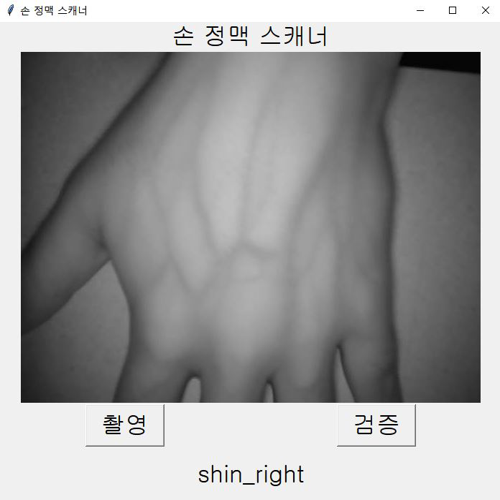

In [8]:
from PIL import Image

image0 = Image.open("images\\live_deeplearning.jpg")
image0 = image0.resize((500, 500))
image0